<a href="https://colab.research.google.com/github/jaimegonzalezc/KC-DeepLearningCV/blob/main/practicadl_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Deep Learning - KeepCoding

## Predicción del precio de la vivienda en Airbnb
En esta práctica se nos pide predecir el precio de una vivienda de Airbnb basándonos por un lado en datos tabulares (1D) y por otro lado en imagenes de las habitaciones (2D) para luego hacer combinaciones entre las predicciones individuales con estrategias de combinación late-fusion y early-fusion.

Por ello, trabajaremos con dos grandes conjuntos de datos, por un lado con los datos tabulares que almacenaremos como dataframe y por otro con un conjunto de imagenes (vectores de dos dimensiones) que normalizaremos.

Dado que se trata de predecir valores continuos y por continuación de la práctica realizada en el módulo de Machine Learning, se va a realizar un problema de **regresión.**

### 1. Importación de los datos
En primer lugar, se van a cargar los datos tabulares del fichero dataset.csv que cuenta con información a cerca de precios de airbnbs en Madrid. Una vez cargados los datos, eliminamos las filas que vengan con la variable objetivo Price vacía y hacemos una previsualización del dataset para conocer mejor que tipo de datos tenemos.

In [ ]:
import cv2
import imageio.v3 as io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy.stats as sp
from tqdm import tqdm
!pip install category_encoders
import category_encoders as ce

np.random.seed(42)

from tqdm import tqdm
from typing import Optional, Union
data = pd.read_csv("data/dataset.csv", sep = ';')
data = data.dropna(subset=['price'])
data.head()

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09


Tras una primera visualización vemos que los datos parecen estar algo sesgados a la ciudad de Boston. Por ello, vamos a sacar un gráfico para ver la cantidad de datos que vienen de esta ciudad.

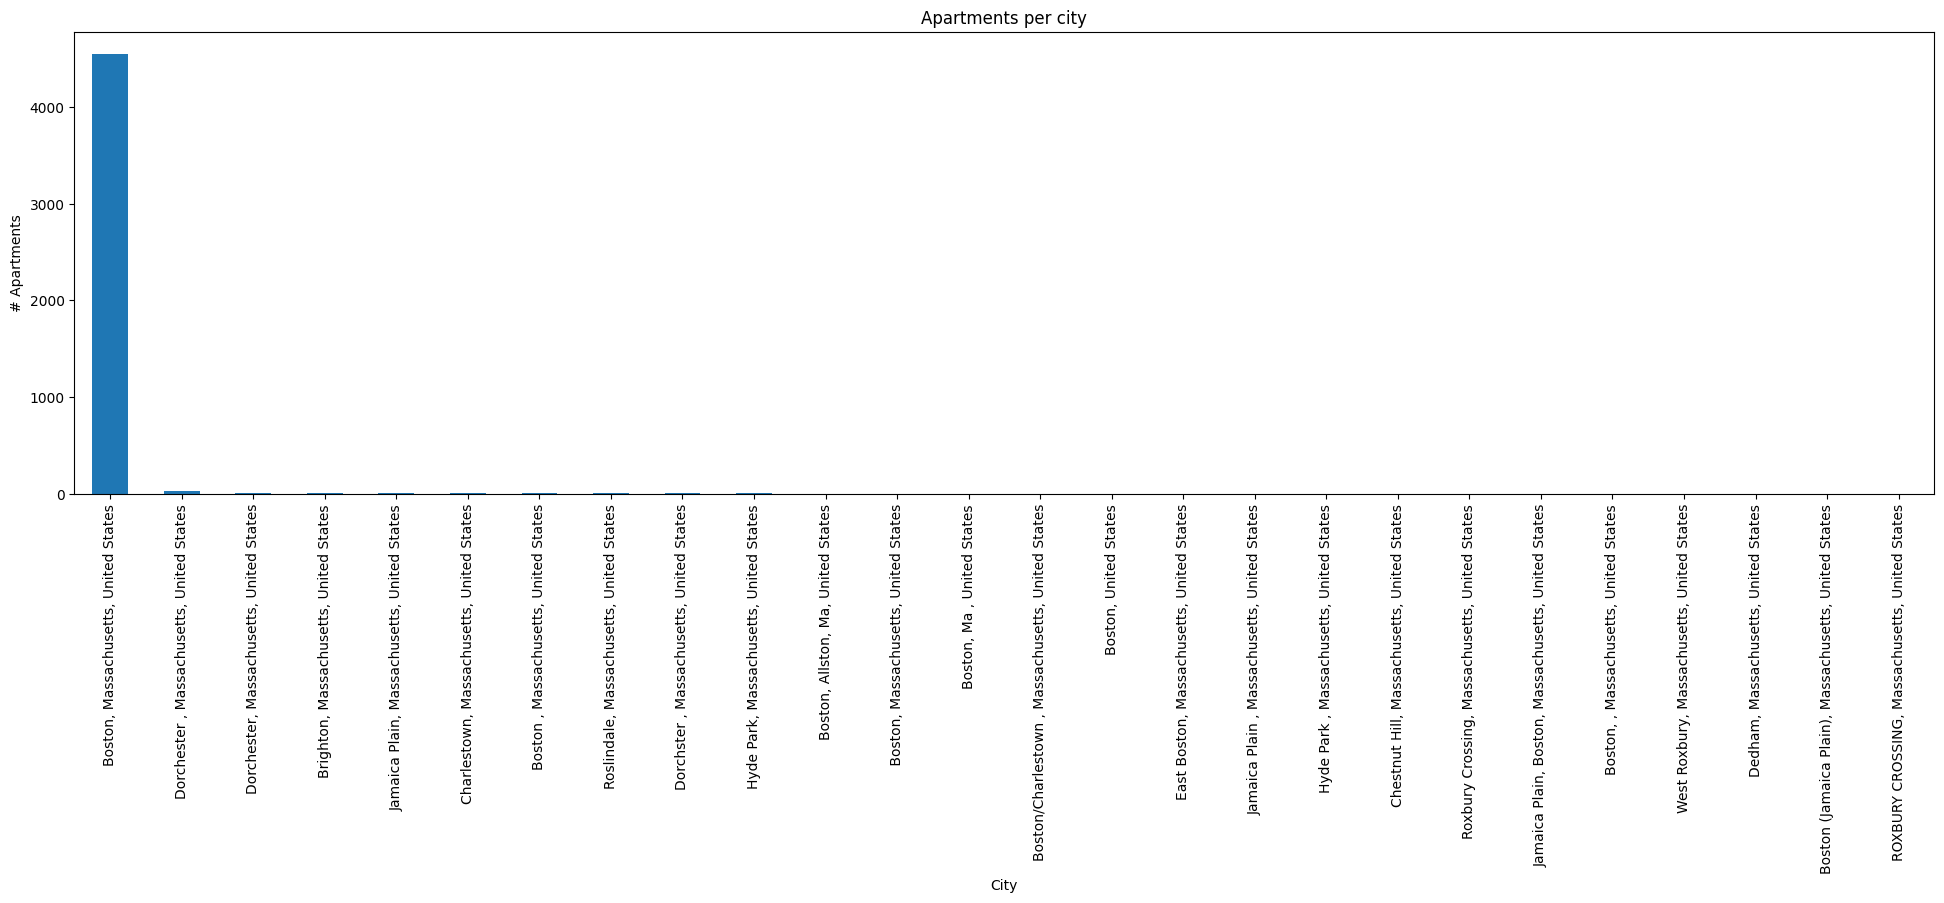

In [ ]:
city_counts = data.neighbourhood.value_counts()
plt.figure(figsize=(24, 6))
city_counts.plot(kind='bar')
plt.title('Apartments per city')
plt.xlabel('City')
plt.ylabel('# Apartments')
plt.xticks(rotation=90)
plt.show()

Ya que la diferencia de datos en la ciudad de Boston es inmensamente mayor al resto de ciudades, vamos a seleccionar solo los registros de Boston, descartando así la variable `neighbourhood`

In [ ]:
boston_data = data[data.neighbourhood == 'Boston, Massachusetts, United States']
boston_data.drop(columns='neighbourhood', axis=1, inplace=True)

<ipython-input-22-1532cbceddf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_data.drop(columns='neighbourhood', axis=1, inplace=True)


Encontramos varios campos con URLs de descarga de imágenes, por ello, vamos a descargar primero estas imágenes y almacenarlas en una variable, obteniendo así el conjunto de datos necesario para la predicción 2D. Primero definimos la función para descarga de imágenes:

In [ ]:

def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:
        pass
  return images[downloaded_idxs], downloaded_idxs

A continuación, descargamos las imágenes y normalizamos valores para encajar entre 0 y 1:

In [ ]:
images, idxs = download_images(boston_data['picture_url'])
images = images.astype("float32") / 255.
images.shape


100%|██████████| 4547/4547 [22:50<00:00,  3.32it/s]


(3723, 224, 224, 3)

A continuación, filtramos acorde en los demás datos para quedarnos solo las filas cuyas imágenes pudieron descargarse:

In [ ]:
filtered_data = boston_data.iloc[idxs]
filtered_data

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7189,1045997580495005942,https://www.airbnb.com/rooms/1045997580495005942,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/prohost-api/H...,22348222,https://www.airbnb.com/users/show/22348222,Maverick,2014-10-09,...,NaN,NaN,NaN,STR-540399,t,87,87,0,0,NaN
7191,1046356755567106626,https://www.airbnb.com/rooms/1046356755567106626,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,275849638,https://www.airbnb.com/users/show/275849638,Steven,2019-07-13,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,t,71,71,0,0,NaN
7192,1046470991404568874,https://www.airbnb.com/rooms/1046470991404568874,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,365116307,https://www.airbnb.com/users/show/365116307,Healing Homes,2020-08-30,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,f,64,64,0,0,NaN
7193,1046490108856067836,https://www.airbnb.com/rooms/1046490108856067836,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,365116307,https://www.airbnb.com/users/show/365116307,Healing Homes,2020-08-30,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,t,64,64,0,0,NaN


Ya que el descargado de imágenes es una tarea bastante lenta, vamos a almacenar esta matriz de imágenes normalizadas para su posterior uso:

In [ ]:
np.save('data/images.npy', images) # Debido al gran tamaño, se añade en el gitignore ya que github no permite archivos tan grandes.
filtered_data.to_csv('data/filtered_data.csv', sep=';', index=False)

Una vez guardados para futuras cargas, volvemos a importar los datos:

In [ ]:
data = pd.read_csv("data/filtered_data.csv", sep=';', encoding = "latin")
images = np.load("data/images.npy")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 71 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3723 non-null   int64  
 1   listing_url                                   3723 non-null   object 
 2   scrape_id                                     3723 non-null   int64  
 3   last_scraped                                  3723 non-null   object 
 4   source                                        3723 non-null   object 
 5   picture_url                                   3723 non-null   object 
 6   host_id                                       3723 non-null   int64  
 7   host_url                                      3723 non-null   object 
 8   host_name                                     3723 non-null   object 
 9   host_since                                    3723 non-null   o

### 2. Split de datos en train/validation/test
A continuación, se va a dividir el conjunto total de datos en subconjunto de train, validation y test. Posteriorimente procederemos con la limpieza de datos tabulares para poder empezar a entrenar los modelos.

Echando un primer vistazo a la información tabular otorgada, encuentro ciertas cosas curiosas que tendré en cuenta a la hora de seleccionar características:
- La variable `bedrooms` está vacía. A priori, diría que el número de habitaciones puede ser una de las características más influyentes en el precio de un airbnb, pero no contamos con esta información, por lo que tendrémos que basarnos en el número de camas y el número de personas que admite.
- La variable bathrooms también está vacía pero tenemos una variable bathrooms_text que nos indica el número de baños y el tipo de baño (privado o compartido) por ello, se crearán dos variables nuevas, una `bathrooms` indicando el número de baños y otra `bathroom_type` que indica qué tipo de baño se ofrece.
- Encontramos dos variables que hacen referencia al tipo de propiedad que se alquila, `property_type` y `room_type`. Teniendo en cuenta que son variables categóricas que tendremos que codificar, se va a elegir solo `room_type` para mayor comodidad y menor redundancia.

Separación de variable target frente al resto de características y división de train y test, para posteriorimente separarar train en train y validation:

In [ ]:
# Separamos target de features
features = data.drop("price", axis=1)
target = data['price'].to_frame()
target['price'] = target['price'].str.replace('$', '').str.replace(',', '').astype(float)
print(features.shape)
print(target.shape)

# Separamos train y test
X_raw, X_test, y_raw, y_test = train_test_split(features, target, test_size=0.25, random_state=1973)
print(X_raw.shape, X_test.shape, y_raw.shape, y_test.shape)

# Separamos train y validation
X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.15, random_state=1973)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3723, 70)
(3723, 1)
(2792, 70) (931, 70) (2792, 1) (931, 1)
(2373, 70) (419, 70) (2373, 1) (419, 1)


Así pues, tenemos 2373 registros para entrenar el modelo, 419 para validarlo y 931 para testear si el modelo es correcto y no tiene overfiting.

### 3. Análisis exploratorio de datos tabulares y limpieza

Una vez separados los conjuntos de datos, ya podemos comenzar con la limpieza y codificación de los datos:

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373 entries, 2563 to 2509
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2373 non-null   int64  
 1   listing_url                                   2373 non-null   object 
 2   scrape_id                                     2373 non-null   int64  
 3   last_scraped                                  2373 non-null   object 
 4   source                                        2373 non-null   object 
 5   picture_url                                   2373 non-null   object 
 6   host_id                                       2373 non-null   int64  
 7   host_url                                      2373 non-null   object 
 8   host_name                                     2373 non-null   object 
 9   host_since                                    2373 non-null   obj

Parece que hay una gran cantidad de columnas y a priori vemos varias que no nos van a servir de nada como URLs, IDs, columnas vacías...

Por ello, vamos a hacer una primera selección de características para limpiar el dataset. Se ha elegido ir eliminando columnas en lugar de crear un nuevo dataframe solo con las características que nos interesan porque a posteriori es más sencillo revisar qué columnas he eliminado, por si he eliminado alguna que no debería, poder así identificarla más rápido.

In [ ]:
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time',
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'bathrooms', 'bedrooms', 'amenities', 'calendar_updated', 'has_availability',
    'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'latitude', 'longitude', 'property_type'
]
X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373 entries, 2563 to 2509
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  2373 non-null   object 
 1   room_type               2373 non-null   object 
 2   accommodates            2373 non-null   int64  
 3   bathrooms_text          2373 non-null   object 
 4   beds                    2344 non-null   float64
 5   minimum_nights          2373 non-null   int64  
 6   maximum_nights          2373 non-null   int64  
 7   number_of_reviews       2373 non-null   int64  
 8   review_scores_rating    1987 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 185.4+ KB


En primer lugar vamos a imputar las variables numéricas que tienen valores nulos:
- Beds -> Al ser muy pocos registros nulos, rellenamos con la media sin producir sesgo.
- review_scores_rating -> se ha identificado que los valores nulos se producen cuando no hay ninguna review, por lo que se va a rellenar con 0.

In [ ]:
# Completar los valores nulos de 'beds' con la media de la columna
X_train['beds'].fillna(X_train['beds'].mean(), inplace=True)

# Completar los valores nulos de 'review_scores_rating' con 0
X_train['review_scores_rating'].fillna(0, inplace=True)

<ipython-input-137-6f5ca579db68>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['beds'].fillna(X_train['beds'].mean(), inplace=True)
<ipython-input-137-6f5ca579db68>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Ahora vamos a crear las dos variables que comentamos antes en referencia a los baños:

In [ ]:
X_train['num_bathrooms'] = X_train['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
X_train['bathroom_type'] = X_train['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in x else 'private')
X_train = X_train.drop("bathrooms_text", axis=1)

Por último vamos a codificar las variables categoricas con target encoder:

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373 entries, 2563 to 2509
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  2373 non-null   object 
 1   room_type               2373 non-null   object 
 2   accommodates            2373 non-null   int64  
 3   beds                    2373 non-null   float64
 4   minimum_nights          2373 non-null   int64  
 5   maximum_nights          2373 non-null   int64  
 6   number_of_reviews       2373 non-null   int64  
 7   review_scores_rating    2373 non-null   float64
 8   num_bathrooms           2373 non-null   float64
 9   bathroom_type           2373 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 203.9+ KB


In [ ]:
target_encoder = ce.TargetEncoder(cols=['neighbourhood_cleansed'])
X_train['neighbourhood_cleansed_encoded'] = target_encoder.fit_transform(X_train['neighbourhood_cleansed'], y_train['price'])
target_encoder = ce.TargetEncoder(cols=['room_type'])
X_train['room_type_encoded'] = target_encoder.fit_transform(X_train['room_type'], y_train['price'])
target_encoder = ce.TargetEncoder(cols=['bathroom_type'])
X_train['bathroom_type_encoded'] = target_encoder.fit_transform(X_train['bathroom_type'], y_train['price'])

# Eliminamos las variables categóricas
X_train.drop(columns=X_train.select_dtypes(include=['object']).columns, inplace=True)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2373 entries, 2563 to 2509
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    2373 non-null   int64  
 1   beds                            2373 non-null   float64
 2   minimum_nights                  2373 non-null   int64  
 3   maximum_nights                  2373 non-null   int64  
 4   number_of_reviews               2373 non-null   int64  
 5   review_scores_rating            2373 non-null   float64
 6   num_bathrooms                   2373 non-null   float64
 7   neighbourhood_cleansed_encoded  2373 non-null   float64
 8   room_type_encoded               2373 non-null   float64
 9   bathroom_type_encoded           2373 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 203.9 KB


Ya tenemos los datos listos para comenzar con el primer modelo
### 4. Modelo 1D / Tabular:
En primer lugar, replicamos todas las modificaciones a los conjuntos de validación y de test:

In [ ]:
# Aplicamos cambios a datos de validación
X_val.drop(columns=columns_to_drop, axis=1, inplace=True)
# Completar los valores nulos de 'beds' con la media de la columna
X_val['beds'].fillna(X_val['beds'].mean(), inplace=True)
# Completar los valores nulos de 'review_scores_rating' con 0
X_val['review_scores_rating'].fillna(0, inplace=True)
X_val['num_bathrooms'] = X_val['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
X_val['bathroom_type'] = X_val['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in x else 'private')
X_val = X_val.drop("bathrooms_text", axis=1)
target_encoder = ce.TargetEncoder(cols=['neighbourhood_cleansed'])
X_val['neighbourhood_cleansed_encoded'] = target_encoder.fit_transform(X_val['neighbourhood_cleansed'], y_val['price'])
target_encoder = ce.TargetEncoder(cols=['room_type'])
X_val['room_type_encoded'] = target_encoder.fit_transform(X_val['room_type'], y_val['price'])
target_encoder = ce.TargetEncoder(cols=['bathroom_type'])
X_val['bathroom_type_encoded'] = target_encoder.fit_transform(X_val['bathroom_type'], y_val['price'])
# Eliminamos las variables categóricas
X_val.drop(columns=X_val.select_dtypes(include=['object']).columns, inplace=True)

# Aplicamos cambios a datos de test
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)
# Completar los valores nulos de 'beds' con la media de la columna
X_test['beds'].fillna(X_test['beds'].mean(), inplace=True)
# Completar los valores nulos de 'review_scores_rating' con 0
X_test['review_scores_rating'].fillna(0, inplace=True)
X_test['num_bathrooms'] = X_test['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
X_test['bathroom_type'] = X_test['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in x else 'private')
X_test = X_test.drop("bathrooms_text", axis=1)
target_encoder = ce.TargetEncoder(cols=['neighbourhood_cleansed'])
X_test['neighbourhood_cleansed_encoded'] = target_encoder.fit_transform(X_test['neighbourhood_cleansed'], y_test['price'])
target_encoder = ce.TargetEncoder(cols=['room_type'])
X_test['room_type_encoded'] = target_encoder.fit_transform(X_test['room_type'], y_test['price'])
target_encoder = ce.TargetEncoder(cols=['bathroom_type'])
X_test['bathroom_type_encoded'] = target_encoder.fit_transform(X_test['bathroom_type'], y_test['price'])
# Eliminamos las variables categóricas
X_test.drop(columns=X_test.select_dtypes(include=['object']).columns, inplace=True)

# Escalamos los valores con MinMaxScaler al tratarse de un problema de regresión
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_val_scaled = X_val.copy()
scalerX = MinMaxScaler(feature_range=(0, 1)).fit(X_train_scaled.iloc[:,0:15])
X_train_scaled.iloc[:,0:15] = scalerX.transform(X_train_scaled.iloc[:,0:15])
X_test_scaled.iloc[:,0:15] = scalerX.transform(X_test_scaled.iloc[:,0:15])
X_val_scaled.iloc[:,0:15] = scalerX.transform(X_val_scaled.iloc[:,0:15])
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
X_val_scaled = np.array(X_val_scaled)
y_train_scaled = np.array(y_train).reshape(-1,1)
y_test_scaled = np.array(y_test).reshape(-1,1)
y_val_scaled = np.array(y_val).reshape(-1,1)
scalerY = MinMaxScaler().fit(y_train_scaled)
y_train_scaled = scalerY.transform(y_train_scaled)
y_test_scaled = scalerY.transform(y_test_scaled)
y_val_scaled = scalerY.transform(y_val_scaled)


<ipython-input-141-33d36b1ae4d5>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val['beds'].fillna(X_val['beds'].mean(), inplace=True)
<ipython-input-141-33d36b1ae4d5>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

PAra el primer modelo tabular, se va a utilizar un modelo con capas densas de 64 neuronas en la capa de entrada y función de activación ReLu. Después tenemos una capa oculta con 32 neuronas y por último tenemos una única neurona de salida, para obtener un valor único al tratarse de una regresión.

Como función de pérdidas se utiliza mínimos cuadrados ya que se adapta muy bien a los problemas de regresión y además, se ha configurado early stopping ya que se identificó que el modelo dejaba de aprender y esto supone una pérdida de computación innecesaria.

Respecto a la selección de los hiperparámetros, no se ha realizado ningún tipo de grid search o otro tipo de técnica de optimización ya que se viendo los resultados iniciales del modelo se considera demasiado simple y se han ido ajustando de forma manual en base al resultado de la gráfica de pérdida para los valores de train y test.

Por ejemplo, el learning rate es bastante bajo, ya que inicialmente se utilizó valores más altos y la gráfica disminuía demasiado rápido y después generaba mucho diente de sierra.

Probablemente no son los hiperparámetros óptimos, pero el resultado es bastante bueno.

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0209 - val_loss: 0.0052
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

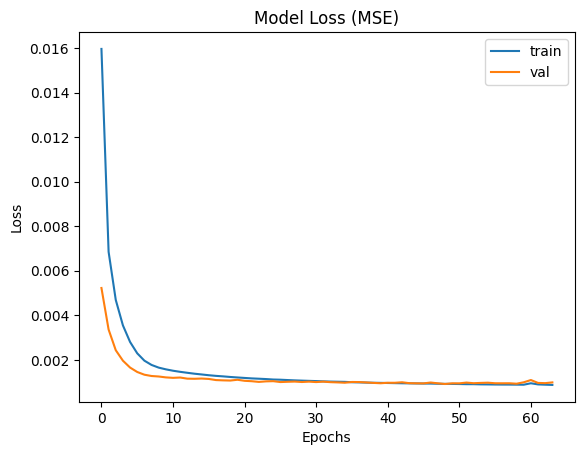

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrenar el modelo con Early Stopping
H_tab = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=100, batch_size=64, callbacks=[early_stopping])

# Graficar la pérdida
plt.plot(H_tab.history['loss'], label='train')
plt.plot(H_tab.history['val_loss'], label='val')
plt.title('Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Como se puede ver, a pesar de haber configurado 100 épocas, el modelo se ha parado en la época 64 gracias a la técnica de Early Stoping.

Calculamos la pérdida con los datos de test:

In [ ]:
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Loss={loss}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3886e-04 
Loss=0.00042025212314911187


Vemos que la pérdida es muy baja, lo cual es de esperar ya que se trata de datos escalados. Pero nos sirve para comparar con los valores de los otros subconjuntos viendo que son muy similares, por lo que no encontramos overfit.

### 5. Modelo